In [77]:
import matplotlib
import matplotlib.pyplot as plt
import numpy

In [78]:
matplotlib.rcParams['figure.figsize'] = (20, 10)

### **Data Generation**

<u>Method *'generate_classifier_data()'* </u>
    
Inputs
- Centroids: A list of centroid vectors, each centroid is the mean of a class in multivariate normal distribution
- Sigmas: A list of covariance matrices, one for each class
- Sizes: A list of the number of samples to generate each class
- Seed: A value for the random number generator 
    
Outputs:
- xs: Data
- ys: Labels
- n_classes: Number of classe

In [79]:
# Any number of data sets (list of centroids & sigmas)
# sizes are len(centroids)
def generate_classifier_data(centroids, sigmas, sizes, seed):
    rng = numpy.random.default_rng(seed=seed)
    
    # Initialize lists for classes and labels
    xs = []
    ys = []
    n_classes = 0 
    
    # Move through data and generate classes and labels
    for i, (c, sigma, size) in enumerate(zip(centroids, sigmas, sizes)):
        classes = rng.multivariate_normal(c, sigma, size=size)
        # List in one column of labels asigned to each class
        labels = numpy.full(shape=(size, 1), fill_value=i)
        
        xs.append(classes)  
        ys.append(labels)
    
    # List in two columns of vectors with label 1 and lable 2 (component x, component y)
    xs = numpy.vstack(xs)
    ys = numpy.vstack(ys)
    n_classes = len(centroids)

    return xs, ys, n_classes

### **RDA Model**

**class RDAClassifier()**

<u>Method *'fit(self, xs, ys, n_classes, alpha)'* </u>
    
Inputs
- xs: Data
- ys: Labels
- n_classes: Number of classes in ys array
- alpha: Number from 0 (LDA) to 1 (QDA)

Outputs
- RDAClassifierResult(self.pi, self.mu, self.sigma): Instance that contains the prior probabilities, mean vectors, and regularized covariance matrices for each class

**class RDAClassifierResult()**

<u>Method *'predict(self, xs)'*</u> 

Inputs:
- xs: Data

Outputs:
- Predictions: Array of the predicted class labels for the input feature xs

<u>Method *'predict_LL(self, x)'*</u>

Inputs: 
- x: Data

Outputs:
- probabilities: Array with the probabilities of belonging to each class 

<u>Method *'viz_everything(self, xs, ys)'*</u>

Inputs:
- xs: Data
- ys: Labels

Outputs: 
- x_p: Array in 2D with the features projected
- predictions: Array in 1D with the predicted class labels for samples in xs


<u>Method *'_log_loss(self, x)'*</u>

Inputs:
- x: Data 

Output:
- log_loss: Array of log loss values for each class

In [87]:
class RDAClassifier():
    def _init_(self):
        pass
    
    def fit(self, xs, ys, n_classes, alpha):
        self.n_k = [] # Number of samples for each class
        self.x = [] # Data points for each class
        self.mu = [] # Mean vector for each class
        self.pi = [] # Prior Probabilities
        cov = []
        cov_final = None # Pooled covariance matrix 
        self.sigma = []

        # Handle multiple classes
        for i in range(n_classes):
            # Number of data in a class
            self.n_k.append(numpy.where(ys == i)[0].shape[0])
            # Data from each class
            self.x.append(xs[numpy.where(ys == i)[0],:])
            # Get the mean of all data of each class
            self.mu.append(numpy.mean(self.x[i], axis=0)) 
            # Get the prior probabilities (pis) of each class
            self.pi.append(self.n_k[i] / numpy.sum(self.n_k))
            # Covariance matrix of each class
            cov.append(numpy.matmul((self.x[i] - self.mu[i]).T, self.x[i] - self.mu[i])/self.n_k[i])
            # Previous calculation to sigma
            if cov_final is None:
                cov_final = cov[i]
            else:
                cov_final += cov[i]
        
        # Compute pooled covariance matrix for regularization
        # (Shared covariance matrix = The same for each class)
        cov_final /= n_classes
        
        # Use regularization parameter alpha
        # (Regularized covariance matrixes = A different matrix for each class)
        for i in range(n_classes):
            self.sigma.append(alpha*cov[i] + (1 - alpha)*cov_final)
            # When alpha = 1 QDA (each class has its covariance matrix)
            # When alpha = 0 LDA (pooled covariace matrox)
            
        return RDAClassifierResult(self.pi, self.mu, self.sigma)

class RDAClassifierResult():
    def __init__(self, pi, mu, sigma):
        self.pi = pi
        self.mu = mu
        self.sigma = sigma

    def predict(self, xs):
        num_classes=len(self.mu)
        scores = [] # contains discriminant scores
        for i in range(num_classes):
            sigma_inv = numpy.linalg.inv(self.sigma[i]) 
            # distance = numpy.matmul(numpy.matmul((p - self.mu[i]).T, sigma_inv), (p - self.mu[i]))
            distance = numpy.einsum('ij,ij->i', (xs - self.mu[i]) @ sigma_inv, (xs - self.mu[i]))
            d_score = -0.5*distance + numpy.log(self.pi[i])-0.5*numpy.log(numpy.linalg.det(self.sigma[i]))
            scores.append(d_score)
        
        scores = numpy.array(scores)  
        predictions = numpy.argmax(scores, axis=0) 
        #predictions = predictions.reshape(xs.shape)  
        
        return predictions
    
    def predict_LL(self, x):
        LL = self._log_loss(x)
        exp_LL = numpy.exp(LL)
        probabilities = exp_LL / numpy.sum(exp_LL, axis=0)
        return probabilities
    
    def viz_everything(self, xs, ys):

        num_classes = len(self.mu)
        sigma_inv_x = []
        p =[]
        x_p =[]
        
        # Projection of xs to reduce data dimension into 2D (just for visualizing purposes)
        if xs.shape[0] > 2:
            for i in range(num_classes):
                sigma_inv_x.append(numpy.linalg.inv(self.sigma[i])) 
                p.append(numpy.linalg.eig(sigma_inv_x[i])[1][:,-2:])
                x_p.append(numpy.matmul(xs[numpy.where(ys == i)[0],:], p[i]))
        
            x_p = numpy.vstack(x_p)
            
        else:
            x_p=xs
            
        predictions = self.predict(xs)
        predictions = numpy.vstack(predictions)
        return x_p, predictions

    def _log_loss(self, x):

        k = len(self.mu)  #n of classes
        log_loss = numpy.zeros(k)

        for i in range(k):
            sigma_inv_i = numpy.linalg.inv(self.sigma[i])
            for j in range(i+1, k):
                sigma_inv_j = numpy.linalg.inv(self.sigma[j])
                sigma_inv_mui = numpy.matmul(sigma_inv_i, x - self.mu[i])
                sigma_inv_muj = numpy.matmul(sigma_inv_j, x - self.mu[j])

                first_term = 1/2*numpy.log(numpy.linalg.det(self.sigma[j])/numpy.linalg.det(self.sigma[i]))
                second_term = -1/2*numpy.matmul((x - self.mu[i]).T, sigma_inv_mui)
                third_term = 1/2*numpy.matmul((x - self.mu[j]).T, sigma_inv_muj)
                forth_term = numpy.log(self.pi[i]/self.pi[j])

                log_loss[i] = first_term + second_term + third_term + forth_term
        
        return log_loss

### **TEST**
**Generate sinthetic data**

- 2D data experiment
- 3D data experiment

**Model metrics**

- Confussion matrix
- Errors
- Accuracy

In [81]:
# Generate 2D (2 features) data to visualize a simple example
c_1=numpy.array([-1,1])
c_2=numpy.array([2,1])
c_3=numpy.array([0,-10])
c_4=numpy.array([-3,-3])
centroid_list = [c_1,c_2,c_3,c_4]
sigma_1 = numpy.array([[1, 0.5], [0.5, 1]])
sigma_2 = numpy.array([[0.7, 0.5], [0.5, 1.2]])
sigma_3 = numpy.array([[1.0, -0.4], [-0.4, 1.0]])
sigma_4 = numpy.array([[1.1, 0.3], [0.3, 0.9]]) 
sigma_list = [sigma_1,sigma_2,sigma_3,sigma_4]
nsamples_1 = 500
nsamples_2 = 500
nsamples_3 = 500
nsamples_4 =350
nsamples_list = [nsamples_1,nsamples_2,nsamples_3,nsamples_4]
xs, ys, n_classes = generate_classifier_data(centroid_list,sigma_list,nsamples_list, 73784)

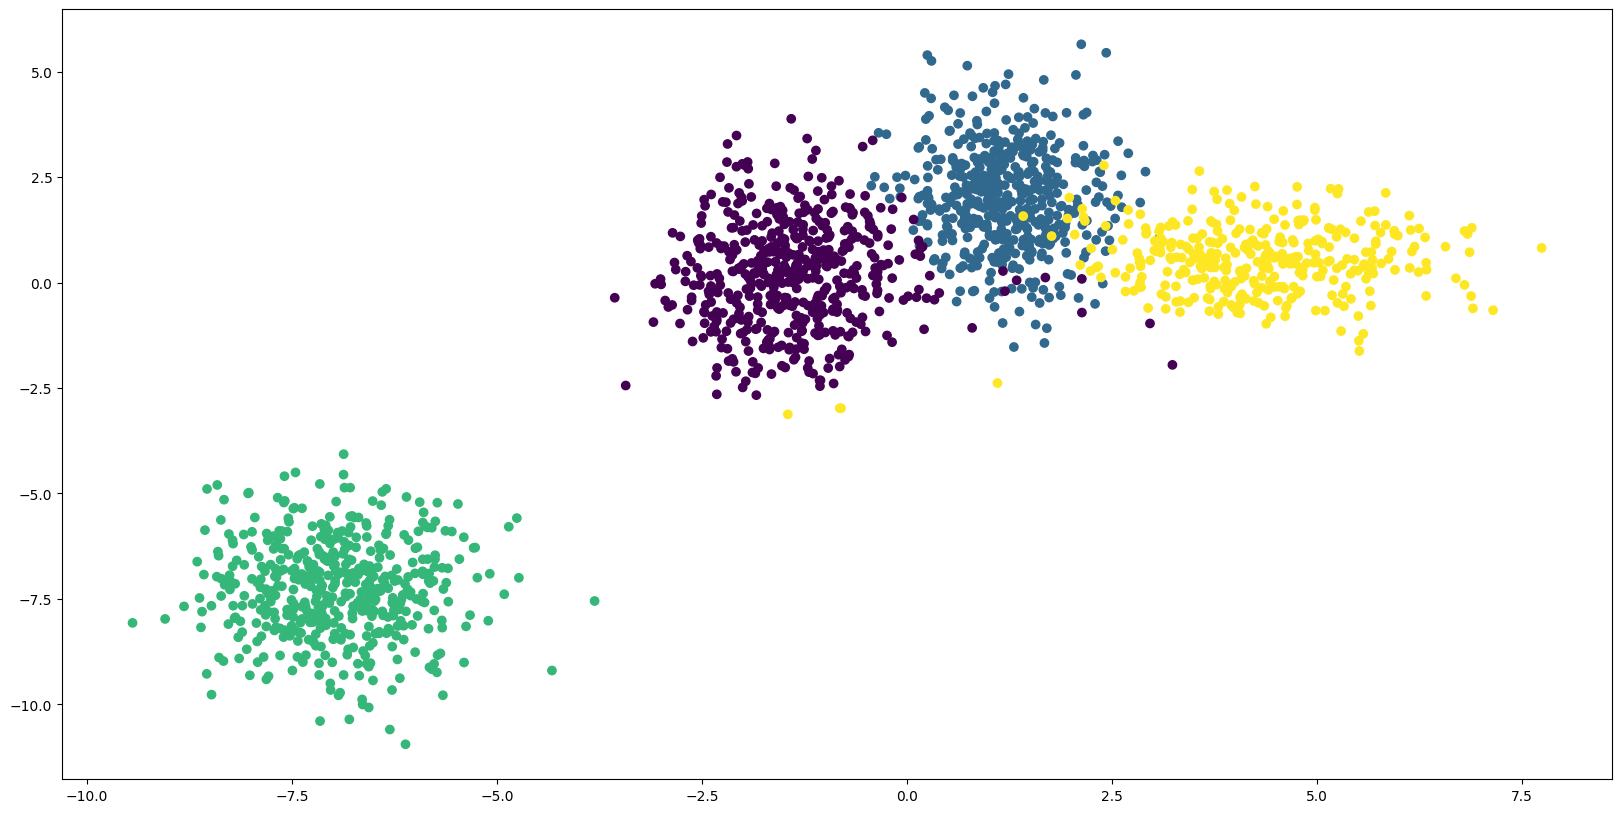

array([3.39688142e-04, 9.62290963e-11, 9.16587877e-13, 9.99660312e-01])

In [82]:
# Plot 2D example

model=RDAClassifier()
alpha = 0.8
result = model.fit(xs, ys, n_classes, alpha)
#result.predict(numpy.array([-1,1]))

x_p, predictions = result.viz_everything(xs, ys)

plt.scatter(x_p[:,0], x_p[:, 1], c=predictions)#in case ys is in 2D format it needs to be in 1D
plt.show()

result.predict_LL([-4,-3])

In [83]:
# Generate 3D train and test data (works with n-dimensional data)
c_1=numpy.array([-1,1,2])
c_2=numpy.array([2,1,3])
c_3=numpy.array([0,-10,4])
c_4=numpy.array([-3,-3,-4])
centroid_list = [c_1,c_2,c_3,c_4]
sigma_1 = numpy.array([[1, 0.5, 0.2], [0.5, 1, 0.3], [0.2, 0.3, 1]])
sigma_2 = numpy.array([[0.7, 0.5, -0.2], [0.5, 1.2, 0.3], [-0.2, 0.3, 0.8]])
sigma_3 = numpy.array([[1.0, -0.4, 0.1], [-0.4, 1.0, 0.2], [0.1, 0.2, 1.2]])
sigma_4 = numpy.array([[1.1, 0.3, 0.1], [0.3, 0.9, 0.2], [0.1, 0.2, 0.8]]) 
sigma_list = [sigma_1,sigma_2,sigma_3,sigma_4]
nsamples_1 = 500
nsamples_2 = 500
nsamples_3 = 500
nsamples_4 =350
nsamples_list = [nsamples_1,nsamples_2,nsamples_3,nsamples_4]
xs, ys, n_classes = generate_classifier_data(centroid_list,sigma_list,nsamples_list, 73784) # This is the training data
xs_test, ys_test, n_classes = generate_classifier_data(centroid_list,sigma_list,nsamples_list, 73784) # Test data



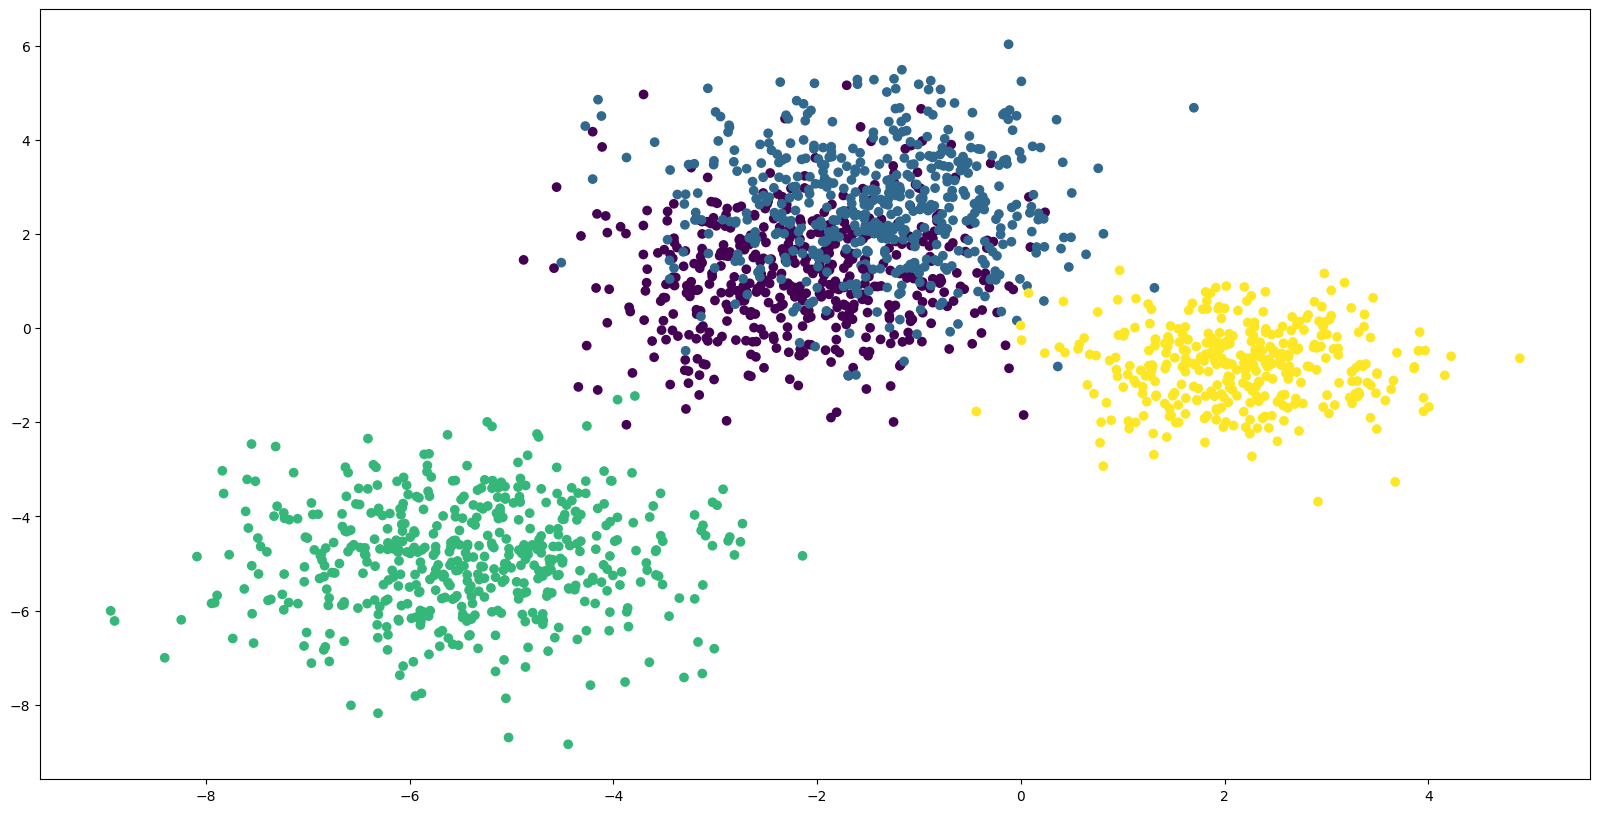

array([9.99989354e-01, 1.06270630e-05, 1.79466709e-08, 7.04581335e-10])

In [84]:
# Plot 3D example

model=RDAClassifier()
alpha = 0.7
result = model.fit(xs, ys, n_classes, alpha)
#result.predict(numpy.array([-1,1]))

x_p, predictions = result.viz_everything(xs, ys)

plt.scatter(x_p[:,0], x_p[:, 1], c=predictions)#in case ys is in 2D format it needs to be in 1D
plt.show()

result.predict_LL([-4,-3, 3])

In [85]:
# Metrics
y_p=result.predict(xs_test)
resulting=numpy.column_stack((ys_test,y_p))

errors = resulting[resulting[:, 0] != resulting[:, 1]]

accuracy = numpy.mean(predictions == ys) * 100
print(f"Accuracy of the model: {accuracy:.2f}%")


Accuracy of the model: 98.86%


In [86]:
# Confusion matrix

ys_test_flat = ys_test.flatten()

n_classes = len(numpy.unique(ys_test_flat))

matrix = numpy.zeros((n_classes, n_classes), dtype=int)
    
# Map each label to an index
label_to_index = {label: i for i, label in enumerate(numpy.unique(ys_test_flat))}
    
# Populate the confusion matrix
for true, pred in zip(ys_test_flat, y_p):
    matrix[label_to_index[true], label_to_index[pred]] += 1
    
print(matrix)

[[485  15   0   0]
 [  6 494   0   0]
 [  0   0 500   0]
 [  0   0   0 350]]
